# TA

In [1]:
# -*- coding: utf-8 -*-
"""
Originally Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""


import numpy as np

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')

## Constant Variables and Functions Defined

In [2]:
hamming = [bin(n).count("1") for n in range(256)]

sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

def cov(x, y):
    return np.cov(x, y)[0][1]

## Load Data

In [3]:
all_traces = np.load('./chipwhisperer/traces.npy')[:-1]
pt = np.load('./chipwhisperer/plain.npy')
knownkey = np.load('./chipwhisperer/key.npy')

### Training Testing Spliting

In [4]:
number_of_training = 9000

In [5]:
tracesTrain = all_traces[0:number_of_training]
ptTrain = pt[0:number_of_training]

# tracesTest = all_traces[9990:9995]
# ptTest  = pt[9990:9995]

outputSbox = [sbox[ptTrain[i][0] ^ knownkey[i][0]]
              for i in range(len(ptTrain))]
outputSboxHW = [hamming[s] for s in outputSbox]


# features: tracesTrain[i]
# labels: outputSboxHW[i]
TracesHW = [[] for _ in range(9)]
for i in range(len(tracesTrain)):
    HW = outputSboxHW[i]
    TracesHW[HW].append(tracesTrain[i])

TracesHW = [np.array(TracesHW[HW]) for HW in range(9)]

### Data Visualization - Distribution

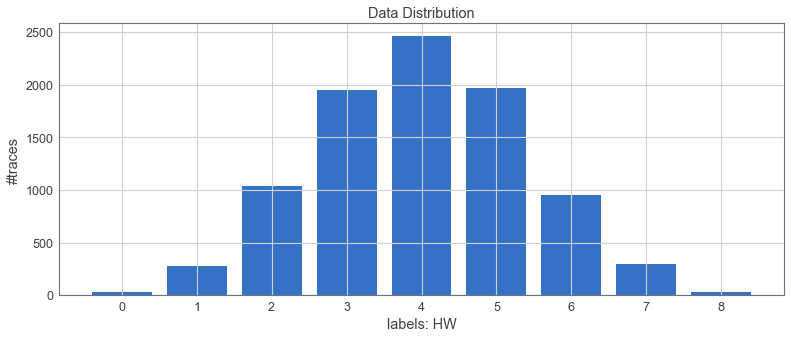

In [6]:
labels_count = [TracesHW[i].shape[0] for i in range(9)] 

plt.figure(figsize=(13,5))
plt.bar(np.arange(0,8+1), labels_count)
plt.xlabel("labels: HW")
plt.ylabel("#traces")
plt.title("Data Distribution")
plt.xticks(np.arange(0,8+1))
# plt.savefig('./figures/TA/data_distribution.pdf', dpi=1200)
plt.show()

### Data Visualization - Points of Interest

For each trace, it has 5,000 features/points. So, there should be a question: Which are the features we need?

In order to select features, we can plot which features/points determine the difference of various 9 classes.

- Means[1] - Means[0] -> differences between class 1 and class 0

- Means[2] - Means[0] -> differences between class 2 and class 0

- Means[2] - Means[1] -> differences between class 2 and class 1

- Means[3] - Means[0] -> differences between class 3 and class 0

- ...

If we sum them up, we can obtain which features among these 5,000 features generated the most significant differences. We can use them to distinguish different categories.

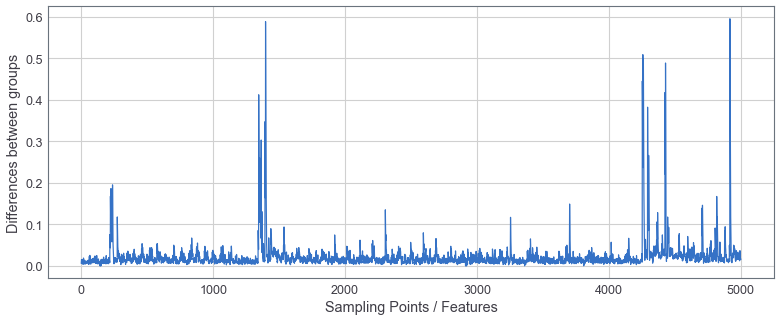

In [7]:
Means = np.zeros((9, len(tracesTrain[0])))
for i in range(9):
    Means[i] = np.average(TracesHW[i], 0)
    
SumDiff = np.zeros(len(tracesTrain[0]))
for i in range(9):
    for j in range(i):
        SumDiff += np.abs(Means[i] - Means[j])

plt.figure(figsize=(13,5))
plt.plot(SumDiff)
plt.xlabel('Sampling Points / Features')
plt.ylabel('Differences between groups')
# plt.savefig('./figures/TA/diff_groups.pdf', dpi=1200)
plt.show()

The higher the spike, the more important the feature is. The feature owning a higher spike is more deterministic and powerful for the label decision.

## Training and Prediction

### Features Selection

In [8]:
SumDiff_old = SumDiff.copy()

features = []
numFeatures = 25 # the number of selected features

# the oscilloscope has a very high sampling rate than the original signal
# so, the neighbors of a point may still stagnate at that point
featureSpacing = 5

for i in range(numFeatures):
    nextFeature = SumDiff.argmax()
    features.append(nextFeature)
    
#     masking window to avoid to select the same feature and its neighbors again
    featureMin = max(0, nextFeature - featureSpacing)
    featureMax = min(nextFeature + featureSpacing, len(SumDiff))
    for j in range(featureMin, featureMax):
        SumDiff[j] = 0

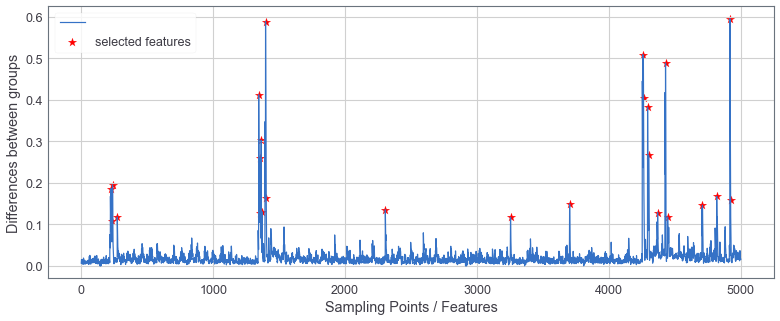

In [9]:
plt.figure(figsize=(13, 5))
plt.plot(SumDiff_old)
plt.scatter(features, SumDiff_old[features], c='red', marker='*', s=80)
plt.xlabel('Sampling Points / Features')
plt.ylabel('Differences between groups')
plt.legend(['', 'selected features'])
# plt.savefig('./figures/TA/selected_features.pdf', dpi=1200)
plt.show()

### Training

In [10]:
meanMatrix = np.zeros((9, numFeatures))
covMatrix  = np.zeros((9, numFeatures, numFeatures))
for HW in range(9):
    for i in range(numFeatures):
        meanMatrix[HW][i] = Means[HW][features[i]]
        for j in range(numFeatures):
            x = TracesHW[HW][:,features[i]]
            y = TracesHW[HW][:,features[j]]
            covMatrix[HW,i,j] = cov(x, y)

### Testing

In [11]:
number_of_tesing = 4

In [12]:
tracesTest = all_traces[9990:9990 + number_of_tesing]
ptTest = pt[9990:9990 + number_of_tesing]

Top 10 guesses:  [ 82  85  37 168 219  67 156 229 234  66]	Highest GE:  10.0

Top 10 guesses:  [ 43 194   7 229 147  69 118 117 148 219]	Highest GE:  9.0

Top 10 guesses:  [179  47 167 146 235   7  43 194 148 147]	Highest GE:  3.0

Top 10 guesses:  [225 201  34  47 159 118 147 194 148  43]	Highest GE:  0.0



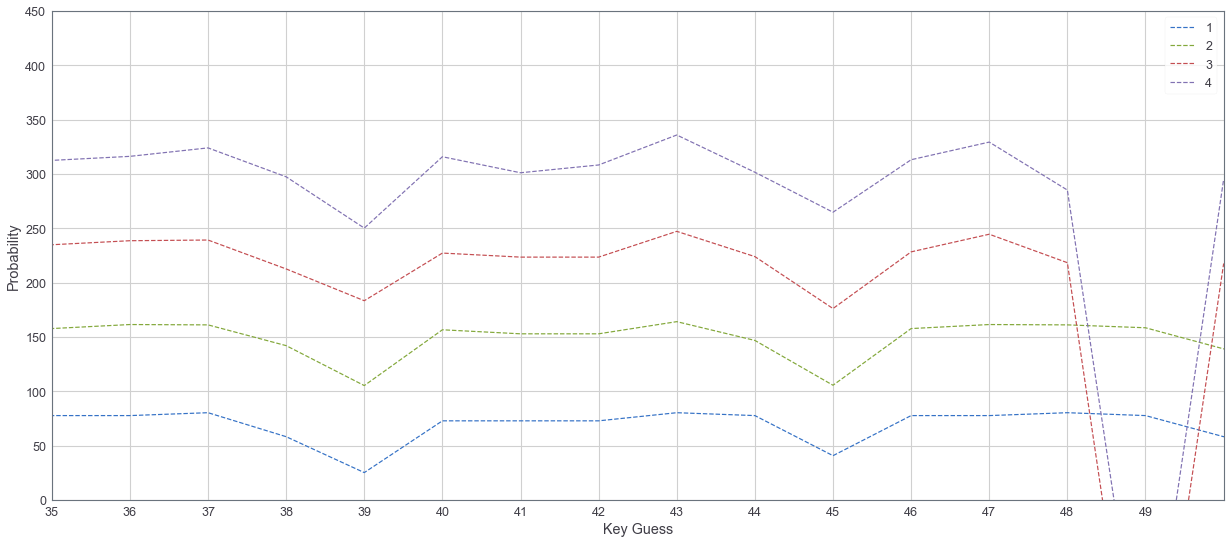

In [13]:
key_rank = np.zeros(16)
P_k = np.zeros(256)

plt.figure(figsize=(21,9))
for j in range(len(tracesTest)):
#     print("Number of taces: ", j)
    test_X = [tracesTest[j][features[i]] for i in range(len(features))]
    
    for kguess in range(0, 256):
        HW = hamming[sbox[ptTest[j][0] ^ kguess]]
        rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
        p_kj = rv.pdf(test_X)
        P_k[kguess] += np.log(p_kj)

    print ("Top 10 guesses: ", P_k.argsort()[-10:], end="\t")    
    tarefs = np.argsort(P_k)[::-1]
    key_rank[0] = list(tarefs).index(knownkey[0][0])
    print("Highest GE: ", key_rank[0], end="\n\n")
    plt.plot(np.arange(0,256), P_k, '--')
   
plt.xlim(35,50)
plt.ylim(0, 450)
plt.xticks(np.arange(35,50))
plt.xlabel('Key Guess')
plt.ylabel('Probability')
plt.legend(np.arange(len(tracesTest))+1)
# plt.savefig('./figures/TA/subkey0_example.pdf', pdi=1200)
plt.show()

### To Find Whole Key

In [14]:
numFeatures = 25
number_of_training = 9000
number_of_tesing = 11

for subkey in range(16):
    print("subkey[%d]"%subkey)
    tracesTrain = all_traces[0:number_of_training]
    ptTrain = pt[0:number_of_training]
    # Generate Hamming Distance Classes
    outputSbox = [sbox[ptTrain[i][subkey] ^ knownkey[i][subkey]]
                  for i in range(len(ptTrain))]
    outputSboxHW = [hamming[s] for s in outputSbox]
    TracesHW = [[] for _ in range(9)]
    for i in range(len(tracesTrain)):
        HW = outputSboxHW[i]
        TracesHW[HW].append(tracesTrain[i])
    TracesHW = [np.array(TracesHW[HW]) for HW in range(9)]

    # Feature Selection
    Means = np.zeros((9, len(tracesTrain[0])))
    for i in range(9):
        Means[i] = np.average(TracesHW[i], 0)
    SumDiff = np.zeros(len(tracesTrain[0]))
    for i in range(9):
        for j in range(i):
            SumDiff += np.abs(Means[i] - Means[j])
    SumDiff_old = SumDiff.copy()
    features = []
    featureSpacing = 5
    for i in range(numFeatures):
        nextFeature = SumDiff.argmax()
        features.append(nextFeature)
        featureMin = max(0, nextFeature - featureSpacing)
        featureMax = min(nextFeature + featureSpacing, len(SumDiff))
        for j in range(featureMin, featureMax):
            SumDiff[j] = 0

    meanMatrix = np.zeros((9, numFeatures))
    covMatrix  = np.zeros((9, numFeatures, numFeatures))
    for HW in range(9):
        for i in range(numFeatures):
            meanMatrix[HW][i] = Means[HW][features[i]]
            for j in range(numFeatures):
                x = TracesHW[HW][:,features[i]]
                y = TracesHW[HW][:,features[j]]
                covMatrix[HW,i,j] = cov(x, y)

    # Guessing
    tracesTest = all_traces[9000:9000 + number_of_tesing]
    ptTest = pt[9000:9000 + number_of_tesing]
    key_rank = np.zeros(16)
    P_k = np.zeros(256)
    for j in range(len(tracesTest)):
        test_X = [tracesTest[j][features[i]] for i in range(len(features))]

        for kguess in range(0, 256):
            HW = hamming[sbox[ptTest[j][subkey] ^ kguess]]
            rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
            p_kj = rv.pdf(test_X)
            P_k[kguess] += np.log(p_kj)

        print ("Top 10 guesses: ", P_k.argsort()[-10:], end="\t")    
        tarefs = np.argsort(P_k)[::-1]
        key_rank[subkey] = list(tarefs).index(knownkey[j][subkey])
        print("Highest GE: ", key_rank[subkey], end="\n\n")

subkey[0]
Top 10 guesses:  [184 183 123 216 217 122 120 119 208 171]	Highest GE:  60.0

Top 10 guesses:  [200 195  82 221 145 185   7 176   3 238]	Highest GE:  25.0

Top 10 guesses:  [139 123 200  82 195 235 204 176 145 185]	Highest GE:  14.0

Top 10 guesses:  [ 38  47 139  28  20  43 195 176 145 235]	Highest GE:  4.0

Top 10 guesses:  [239  74  38  71 200 145 180 139  43 235]	Highest GE:  1.0

Top 10 guesses:  [195  31  68 194  71 200 116  74  38  43]	Highest GE:  0.0

Top 10 guesses:  [213 195  68 194  71 200 116  74  38  43]	Highest GE:  0.0

Top 10 guesses:  [205  31 231  38 116  68  71 200  74  43]	Highest GE:  0.0

Top 10 guesses:  [131 145  33  74 205 231  68  71 116  43]	Highest GE:  0.0

Top 10 guesses:  [119 153 116 205 251 131  71  33  68  43]	Highest GE:  0.0

Top 10 guesses:  [251 110 205 131 119 153  71  33  68  43]	Highest GE:  0.0

subkey[1]
Top 10 guesses:  [ 70  75 186 185 182  80  82  86 190 127]	Highest GE:  25.0

Top 10 guesses:  [ 41 150 126  46  60 131 230 157 16

Top 10 guesses:  [177 195 191 201 188  52 225 178 147 247]	Highest GE:  0.0

subkey[10]
Top 10 guesses:  [185 182 181  83 177  89  93  95  79 255]	Highest GE:  43.0

Top 10 guesses:  [ 54  21  30  33  95  38  79  68 203 255]	Highest GE:  8.0

Top 10 guesses:  [ 34 242  79  68  54 158  21  30   1 255]	Highest GE:  3.0

Top 10 guesses:  [ 43   1  32   9 122  50 255 249 158  21]	Highest GE:  0.0

Top 10 guesses:  [239  41  50 135 249  70   9 255 158  21]	Highest GE:  0.0

Top 10 guesses:  [ 43  59   9   1 239  41  50 255 158  21]	Highest GE:  0.0

Top 10 guesses:  [ 43 140  15  50  59   1 239 255 158  21]	Highest GE:  0.0

Top 10 guesses:  [ 74 140  70  15  59   1 239 255 158  21]	Highest GE:  0.0

Top 10 guesses:  [ 50  89  96  59   1  20  15 255 158  21]	Highest GE:  0.0

Top 10 guesses:  [122  59 248  96  43  50  20 158 255  21]	Highest GE:  0.0

Top 10 guesses:  [ 41 252  74  89 248  19  55  96 158  21]	Highest GE:  0.0

subkey[11]
Top 10 guesses:  [209  52 162 165 231 239 112 229 136

## Pooled Template Attack Assignment

In [15]:
numFeatures = 25
number_of_training = 5000
number_of_tesing = 9
number_of_additional = 5

for subkey in range(16):
    print("subkey[%d]" % subkey)
    tracesTrain = all_traces[0:number_of_training]
    ptTrain = pt[0:number_of_training]
    # Generate Hamming Distance Classes
    outputSbox = [
        sbox[ptTrain[i][subkey] ^ knownkey[i][subkey]]
        for i in range(len(ptTrain))
    ]
    outputSboxHW = [hamming[s] for s in outputSbox]
    TracesHW = [[] for _ in range(9)]
    for i in range(len(tracesTrain)):
        HW = outputSboxHW[i]
        TracesHW[HW].append(tracesTrain[i])
    TracesHW = [np.array(TracesHW[HW]) for HW in range(9)]

    # Feature Selection
    Means = np.zeros((9, len(tracesTrain[0])))
    for i in range(9):
        Means[i] = np.average(TracesHW[i], 0)
    SumDiff = np.zeros(len(tracesTrain[0]))
    for i in range(9):
        for j in range(i):
            SumDiff += np.abs(Means[i] - Means[j])
    SumDiff_old = SumDiff.copy()
    features = []
    featureSpacing = 5
    for i in range(numFeatures):
        nextFeature = SumDiff.argmax()
        features.append(nextFeature)
        featureMin = max(0, nextFeature - featureSpacing)
        featureMax = min(nextFeature + featureSpacing, len(SumDiff))
        for j in range(featureMin, featureMax):
            SumDiff[j] = 0

    meanMatrix = np.zeros((9, numFeatures))
    covMatrix = np.zeros((9, numFeatures, numFeatures))
    for HW in range(9):
        for i in range(numFeatures):
            meanMatrix[HW][i] = Means[HW][features[i]]
            for j in range(numFeatures):
                x = TracesHW[HW][:, features[i]]
                y = TracesHW[HW][:, features[j]]
                covMatrix[HW, i, j] = cov(x, y)
    # in pooled template attack, we use the mean of 9(=the number of labels) the covariance matrix
    # it may be less powerful since it loses the information of "noise" for each specific class.
    # for each class, the noise is estimated less precisely
    pooled_covMatrix = covMatrix.mean(axis=0)

    # Guessing
    tracesTest = all_traces[9000:9000 + number_of_tesing + number_of_additional]
    ptTest = pt[9000:9000 + number_of_tesing + number_of_additional]
    key_rank = np.zeros(16)
    P_k = np.zeros(256)
    for j in range(len(tracesTest)):
        test_X = [tracesTest[j][features[i]] for i in range(len(features))]

        for kguess in range(0, 256):
            HW = hamming[sbox[ptTest[j][subkey] ^ kguess]]
            rv = multivariate_normal(meanMatrix[HW], pooled_covMatrix)
            p_kj = rv.pdf(test_X)
            P_k[kguess] += np.log(p_kj)

        print("Top 10 guesses: ", P_k.argsort()[-10:], end="\t")
        tarefs = np.argsort(P_k)[::-1]
        key_rank[subkey] = list(tarefs).index(knownkey[j][subkey])
        print("Highest GE: ", key_rank[subkey], end="\n\n")

subkey[0]
Top 10 guesses:  [182 181 180 175  32 168  37  38 160 172]	Highest GE:  24.0

Top 10 guesses:  [185 176 238 235 160  68 195 200 204  82]	Highest GE:  28.0

Top 10 guesses:  [175 239 185 145 176  82 200 235 204 195]	Highest GE:  11.0

Top 10 guesses:  [ 47 180  20  28  43 176 145 239 195 235]	Highest GE:  5.0

Top 10 guesses:  [ 74 176 145 239 195 200 139 180  43 235]	Highest GE:  1.0

Top 10 guesses:  [ 71  92 195 200 116 194  68  38  74  43]	Highest GE:  0.0

Top 10 guesses:  [213  71 195 200 116 194  68  38  74  43]	Highest GE:  0.0

Top 10 guesses:  [213 203  38  33  71 200  68 116  74  43]	Highest GE:  0.0

Top 10 guesses:  [205 119 203  74 231  33  71  68 116  43]	Highest GE:  0.0

Top 10 guesses:  [251 205 131 203 116 119  71  33  68  43]	Highest GE:  0.0

Top 10 guesses:  [ 93 131 110 116 203 119  71  33  68  43]	Highest GE:  0.0

Top 10 guesses:  [193 165 251 219 131 205  71 119  68  43]	Highest GE:  0.0

Top 10 guesses:  [ 24 213 205 180 251 131 119  71  68  43]	High

Top 10 guesses:  [114 128  37 176 190 250 184  68 168 166]	Highest GE:  0.0

Top 10 guesses:  [ 55   9 176 190 128 250  37 184 168 166]	Highest GE:  0.0

Top 10 guesses:  [  9 190 114  58  55 176  37 184 168 166]	Highest GE:  0.0

Top 10 guesses:  [128  37 190 114  51  55 176 184 168 166]	Highest GE:  0.0

Top 10 guesses:  [162  55  16 128 168  37 190 176 114 166]	Highest GE:  0.0

subkey[8]
Top 10 guesses:  [217  93  90  87  86 222 183 150 146 170]	Highest GE:  12.0

Top 10 guesses:  [158  33 186  38 153 145  57 180 181  46]	Highest GE:  15.0

Top 10 guesses:  [255 187 220  88 210 177  86 186 190 171]	Highest GE:  0.0

Top 10 guesses:  [ 35 102   9 217 216 190  88 254 177 171]	Highest GE:  0.0

Top 10 guesses:  [ 18  20 126 190  88  86 216 254 177 171]	Highest GE:  0.0

Top 10 guesses:  [  9 191 239  18  88 254 190  86 171 177]	Highest GE:  1.0

Top 10 guesses:  [254 239 119   9 191  88  86 190 171 177]	Highest GE:  1.0

Top 10 guesses:  [190 254 239   9 119 191  88  86 171 177]	Highe

Top 10 guesses:  [ 52 240  90  76  68  54  10  82 122  60]	Highest GE:  0.0

Top 10 guesses:  [ 52  90 116  68  73 240  54  82 122  60]	Highest GE:  0.0

Top 10 guesses:  [218  52  90  73  68 240  82  54 122  60]	Highest GE:  0.0

Top 10 guesses:  [ 90 116  68 240  52 218  82  54 122  60]	Highest GE:  0.0

Top 10 guesses:  [128 219 116 240  50 218  82  54 122  60]	Highest GE:  0.0

Top 10 guesses:  [ 90 128 116  82 219 240  50  54 122  60]	Highest GE:  0.0

Top 10 guesses:  [218 219 240 116  90  82  50  54 122  60]	Highest GE:  0.0

Top 10 guesses:  [106 218 240 219 122  90  82  50  54  60]	Highest GE:  0.0

Top 10 guesses:  [218 106  14 219  90 122  82  50  54  60]	Highest GE:  0.0

